## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [78]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
# from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [79]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?', header=None, index_col=['ID'], names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* There are 16 Bare Nuclei entries missing and marked as "?". Those question marks were replaced as NaN during data loading. 
* All the NaN entries are filled with zero.

In [105]:
data = data.fillna(0)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000,1880.000000
mean,0.458027,0.346669,0.351625,0.295321,0.312792,0.440990,0.348827,0.301569,0.122107,0.512766
std,0.313509,0.346798,0.332184,0.332037,0.258073,0.375612,0.273010,0.351580,0.211911,0.499970
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.234367,0.032384,0.035481,0.033513,0.128546,0.107396,0.133169,0.028634,0.033459,0.000000
50%,0.444613,0.240683,0.241420,0.137887,0.225819,0.210143,0.236428,0.046065,0.033459,1.000000
75%,0.756294,0.652275,0.646600,0.470637,0.443897,0.951790,0.644656,0.550726,0.056801,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Value ranges of data columns

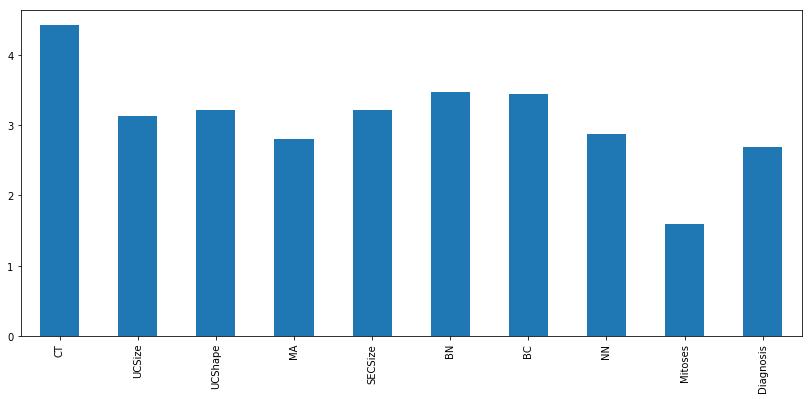

In [82]:
# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
data_mean = data.describe().loc['mean']
data_mean.plot(kind='bar', figsize=(14,6))

#### Samples from dataset labled as B

In [83]:
data_B = data[data['Diagnosis'] == 2]
data_B.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.0
mean,2.956332,1.325328,1.443231,1.364629,2.120087,1.305677,2.100437,1.290393,1.063319,2.0
std,1.674318,0.907694,0.997836,0.996830,0.917130,1.182666,1.080339,1.058856,0.501995,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.0
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.0
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.0
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,9.000000,8.000000,2.0


#### Samples from dataset labeled as M

In [84]:
data_M = data[data['Diagnosis'] == 4]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,7.195021,6.572614,6.560166,5.547718,5.298755,7.564315,5.979253,5.863071,2.589212,4.0
std,2.428849,2.719512,2.562045,3.210465,2.451606,3.180182,2.273852,3.350672,2.557939,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.0
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000,4.0
75%,10.000000,10.000000,9.000000,8.000000,6.000000,10.000000,7.000000,10.000000,3.000000,4.0
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.0


#### Bar chart of the total numbers of B and M

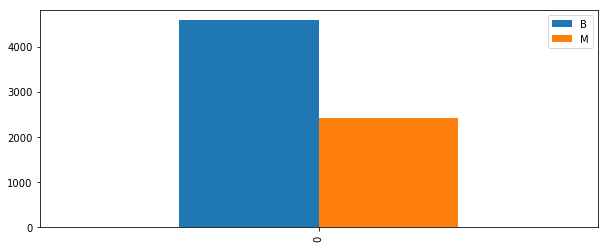

In [85]:
B_M_data = {'B': [data_B.size], 'M': [data_M.size]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))

#### Define a data generation function with random noise

In [106]:
def generateData(data1):
    # make a copy of data
    data2 = data1.copy()

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)
    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Expand the set of data samples labeled as M

In [87]:
data_M_copy = data_M.copy();

new_data_M = generateData(data_M_copy)
data_M = data_M.append(new_data_M, ignore_index=True)

data_M = data_M[data_M['Diagnosis'] >= 4.0]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.0
mean,7.195912,6.574960,6.560457,5.549666,5.302686,7.558868,5.979975,5.860795,2.583027,4.0
std,2.428761,2.713099,2.561894,3.204356,2.454513,3.175825,2.273523,3.349431,2.555241,0.0
min,0.982413,1.000000,1.000000,0.801530,1.000000,-0.120392,1.000000,0.787189,0.794808,4.0
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,7.998451,6.034267,6.140016,5.000000,5.000000,9.937419,6.973972,6.000000,1.000000,4.0
75%,10.000000,9.952878,9.000000,8.040527,6.151369,10.000000,7.150941,9.819572,3.000000,4.0
max,10.281800,10.201488,10.267486,10.131404,10.216988,10.190957,10.000000,10.236294,10.143508,4.0


#### Bar chart of the total numbers of B and M after expanding the set of samples labeled as M

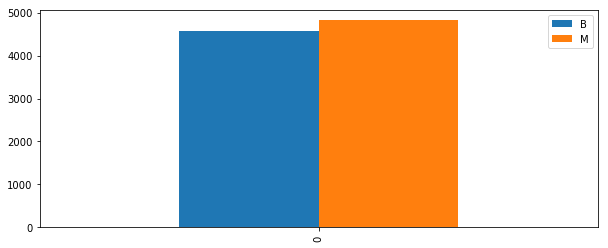

In [88]:
B_M_data = {'B': [data_B.size], 'M': [data_M.size]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))

#### Combine the new set of M samples with the original set of B samples into one new dataset

In [89]:

data = data_B.append(data_M, ignore_index=True)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,5.130244,4.017160,4.067170,3.510574,3.752015,4.512100,4.089732,3.633940,1.842573,3.025532
std,2.980167,3.326273,3.224254,3.181784,2.455350,3.953076,2.641977,3.393627,2.011182,1.000206
min,0.982413,1.000000,1.000000,0.801530,1.000000,-0.120392,1.000000,0.787189,0.794808,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,4.000000
75%,8.000000,7.000000,7.000000,5.067016,5.000000,9.966910,7.000000,6.000000,1.087991,4.000000
max,10.281800,10.201488,10.267486,10.131404,10.216988,10.190957,10.000000,10.236294,10.143508,4.000000


#### Expand the new combined dataset

In [90]:
data_copy = data;

new_data = generateData(data_copy)
data = data.append(new_data, ignore_index=True)

data = data.fillna(0)

print("data size = ", data.shape[0])

('data size = ', 1880)


#### Scale dataset to the range of [0, 1]

In [91]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [92]:
diagnosis = data['Diagnosis']
features = data.drop(['Diagnosis'], axis = 1)

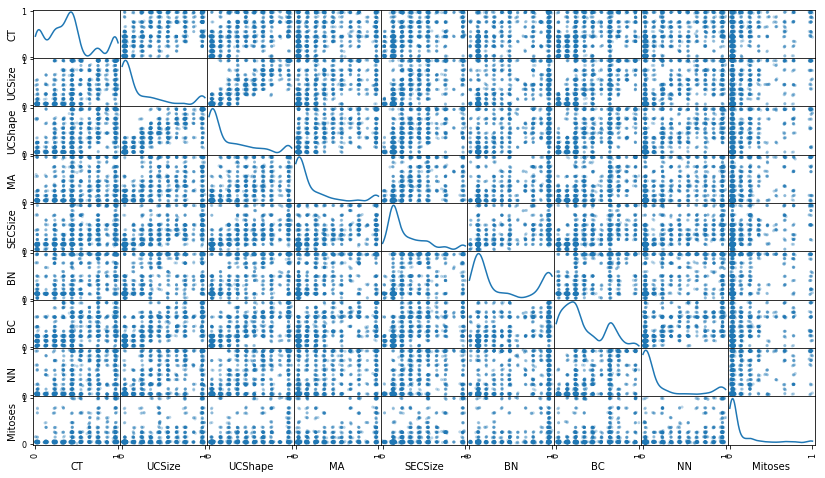

In [93]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

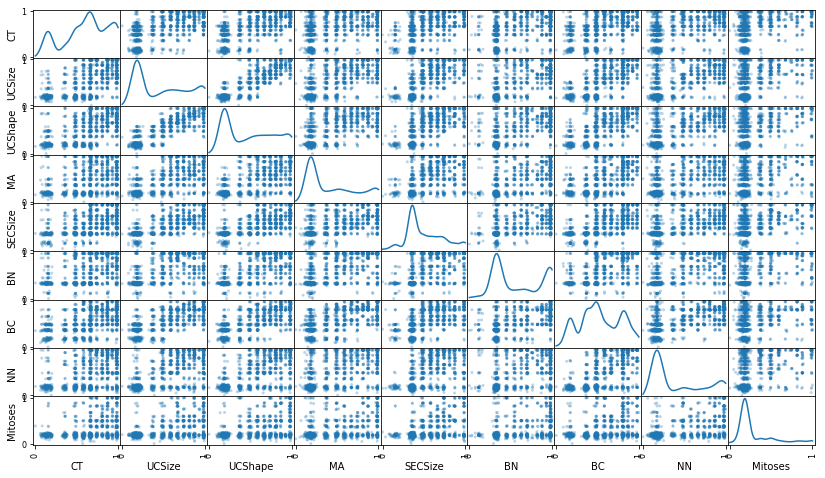

In [94]:
# Scale the data using squared root transformation
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
# sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [95]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [96]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [97]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [98]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.98085106382978726)


#### Deep learning

In [99]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

#### Define NN Architecture
* add Dropout(0.5) does not produce noticable performance in accuracy once the epochs >= 500.

In [100]:
model = Sequential()

#Define your architecture.
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_3 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 50        
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model

In [101]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy'])

#### Train NN Model

In [102]:
model.fit(X_train, y_train, epochs=800, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571

Epoch 1/500
1410/1410 [==============================] - 0s - loss: 0.6795 - binary_accuracy: 0.5184     
Epoch 2/500
1410/1410 [==============================] - 0s - loss: 0.6437 - binary_accuracy: 0.5730     
Epoch 3/500
1410/1410 [==============================] - 0s - loss: 0.6258 - binary_accuracy: 0.6149     
Epoch 4/500
1410/1410 [==============================] - 0s - loss: 0.5943 - binary_accuracy: 0.6603     
Epoch 5/500
1410/1410 [==============================] - 0s - loss: 0.5778 - binary_accuracy: 0.6816     
Epoch 6/500
1410/1410 [==============================] - 0s - loss: 0.5551 - binary_accuracy: 0.6950     
Epoch 7/500
1410/1410 [==============================] - 0s - loss: 0.5360 - binary_accuracy: 0.7177     
Epoch 8/500
1410/1410 [==============================] - 0s - loss: 0.5076 - binary_accuracy: 0.7390     
Epoch 9/500
1410/1410 [==============================] - 0s - loss: 0.4759 - binary_accuracy: 0.7738     
Epoch 10/500
1410/1410 [======================

1410/1410 [==============================] - 0s - loss: 0.3003 - binary_accuracy: 0.8113     
Epoch 78/500
1410/1410 [==============================] - 0s - loss: 0.2941 - binary_accuracy: 0.8234     
Epoch 79/500
1410/1410 [==============================] - 0s - loss: 0.2800 - binary_accuracy: 0.8319     
Epoch 80/500
1410/1410 [==============================] - 0s - loss: 0.3103 - binary_accuracy: 0.8156     
Epoch 81/500
1410/1410 [==============================] - 0s - loss: 0.3081 - binary_accuracy: 0.8128     
Epoch 82/500
1410/1410 [==============================] - 0s - loss: 0.3040 - binary_accuracy: 0.8078     
Epoch 83/500
1410/1410 [==============================] - 0s - loss: 0.3100 - binary_accuracy: 0.8121     
Epoch 84/500
1410/1410 [==============================] - 0s - loss: 0.2832 - binary_accuracy: 0.8064     
Epoch 85/500
1410/1410 [==============================] - 0s - loss: 0.2982 - binary_accuracy: 0.8028     
Epoch 86/500
1410/1410 [==========================

1410/1410 [==============================] - 0s - loss: 0.2835 - binary_accuracy: 0.8135     
Epoch 154/500
1410/1410 [==============================] - 0s - loss: 0.3125 - binary_accuracy: 0.8284     
Epoch 155/500
1410/1410 [==============================] - 0s - loss: 0.3097 - binary_accuracy: 0.8021     
Epoch 156/500
1410/1410 [==============================] - 0s - loss: 0.2949 - binary_accuracy: 0.8213     
Epoch 157/500
1410/1410 [==============================] - 0s - loss: 0.2997 - binary_accuracy: 0.8092     
Epoch 158/500
1410/1410 [==============================] - 0s - loss: 0.2753 - binary_accuracy: 0.8312     
Epoch 159/500
1410/1410 [==============================] - 0s - loss: 0.2804 - binary_accuracy: 0.8262     
Epoch 160/500
1410/1410 [==============================] - 0s - loss: 0.2948 - binary_accuracy: 0.8220     
Epoch 161/500
1410/1410 [==============================] - 0s - loss: 0.2803 - binary_accuracy: 0.8184     
Epoch 162/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2280 - binary_accuracy: 0.8823     
Epoch 229/500
1410/1410 [==============================] - 0s - loss: 0.2244 - binary_accuracy: 0.8915     
Epoch 230/500
1410/1410 [==============================] - 0s - loss: 0.2334 - binary_accuracy: 0.8929     
Epoch 231/500
1410/1410 [==============================] - 0s - loss: 0.2357 - binary_accuracy: 0.9014     
Epoch 232/500
1410/1410 [==============================] - 0s - loss: 0.2286 - binary_accuracy: 0.8979     
Epoch 233/500
1410/1410 [==============================] - 0s - loss: 0.2430 - binary_accuracy: 0.8872     
Epoch 234/500
1410/1410 [==============================] - 0s - loss: 0.2274 - binary_accuracy: 0.8986     
Epoch 235/500
1410/1410 [==============================] - 0s - loss: 0.2055 - binary_accuracy: 0.9035     
Epoch 236/500
1410/1410 [==============================] - 0s - loss: 0.2144 - binary_accuracy: 0.9014     
Epoch 237/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2321 - binary_accuracy: 0.8851     
Epoch 304/500
1410/1410 [==============================] - 0s - loss: 0.2235 - binary_accuracy: 0.8936     
Epoch 305/500
1410/1410 [==============================] - 0s - loss: 0.2302 - binary_accuracy: 0.8837     
Epoch 306/500
1410/1410 [==============================] - 0s - loss: 0.2267 - binary_accuracy: 0.8915     
Epoch 307/500
1410/1410 [==============================] - 0s - loss: 0.2192 - binary_accuracy: 0.8879     
Epoch 308/500
1410/1410 [==============================] - 0s - loss: 0.2236 - binary_accuracy: 0.8936     
Epoch 309/500
1410/1410 [==============================] - 0s - loss: 0.2210 - binary_accuracy: 0.8936     
Epoch 310/500
1410/1410 [==============================] - 0s - loss: 0.2267 - binary_accuracy: 0.8872     
Epoch 311/500
1410/1410 [==============================] - 0s - loss: 0.2257 - binary_accuracy: 0.8901     
Epoch 312/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2157 - binary_accuracy: 0.8979     
Epoch 379/500
1410/1410 [==============================] - 0s - loss: 0.2110 - binary_accuracy: 0.8950     
Epoch 380/500
1410/1410 [==============================] - 0s - loss: 0.2215 - binary_accuracy: 0.8879     
Epoch 381/500
1410/1410 [==============================] - 0s - loss: 0.2292 - binary_accuracy: 0.8865     
Epoch 382/500
1410/1410 [==============================] - 0s - loss: 0.2110 - binary_accuracy: 0.9050     
Epoch 383/500
1410/1410 [==============================] - 0s - loss: 0.2308 - binary_accuracy: 0.8879     
Epoch 384/500
1410/1410 [==============================] - 0s - loss: 0.2215 - binary_accuracy: 0.8986     
Epoch 385/500
1410/1410 [==============================] - 0s - loss: 0.2307 - binary_accuracy: 0.8830     
Epoch 386/500
1410/1410 [==============================] - 0s - loss: 0.2319 - binary_accuracy: 0.8929     
Epoch 387/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2151 - binary_accuracy: 0.8957     
Epoch 454/500
1410/1410 [==============================] - 0s - loss: 0.2009 - binary_accuracy: 0.9057     
Epoch 455/500
1410/1410 [==============================] - 0s - loss: 0.1885 - binary_accuracy: 0.9113     
Epoch 456/500
1410/1410 [==============================] - 0s - loss: 0.2137 - binary_accuracy: 0.8908     
Epoch 457/500
1410/1410 [==============================] - 0s - loss: 0.2227 - binary_accuracy: 0.8936     
Epoch 458/500
1410/1410 [==============================] - 0s - loss: 0.2221 - binary_accuracy: 0.8929     
Epoch 459/500
1410/1410 [==============================] - 0s - loss: 0.2157 - binary_accuracy: 0.8943     
Epoch 460/500
1410/1410 [==============================] - 0s - loss: 0.1992 - binary_accuracy: 0.9043     
Epoch 461/500
1410/1410 [==============================] - 0s - loss: 0.2199 - binary_accuracy: 0.8965     
Epoch 462/500
1410/1410 [=================

#### Test NN Model

In [103]:
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

 16/470 [>.............................] - ETA: 0s('score = ', [0.082265709126566319, 0.97872340425531912])


#### Draw ROC Curve

 32/470 [=>............................] - ETA: 0s

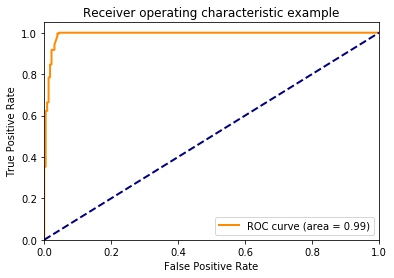

In [104]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()